In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Union

import numpy as np
import pandas as pd
import seaborn as sns
from ecgdetectors import Detectors
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from systole import import_ppg
from systole.utils import input_conversion, to_neighbour
from systole.detection import interpolate_clipping
from systole.plots import plot_raw

from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

sns.set_context('talk')

Loading BokehJS ...

# Estimating respiration from photoplethysmography

In [2]:
ppg_df = import_ppg()

In [3]:
show(
    plot_raw(ppg_df.ppg, sfreq=75, backend="bokeh")
)

In [4]:
def ppg_components(
    x: Union[List, np.ndarray],
    sfreq: int = 75,
    win: float = 0.75,
    new_sfreq: int = 1000,
    clipping: bool = True,
    noise_removal: bool = True,
    peak_enhancement: bool = True,
    distance: float = 0.3,
    clean_extra: bool = False,
) -> Tuple[np.ndarray, np.ndarray]:
    """A simple systolic peak finder for PPG signals.
    This method uses a rolling average + standard deviation
    approach to update a detection threshold. All the peaks found
    above this threshold are potential systolic peaks.
    Parameters
    ----------
    x : np.ndarray or list
        The pulse oximeter time series.
    sfreq : int
        The sampling frequency. Default is set to 75 Hz.
    win : int
        Window size (in seconds) used to compute the threshold (i.e.
        rolling mean + standard deviation).
    new_sfreq : int
        If resample is *True*, the new sampling frequency.
    resample : boolean
        If `True` (default), will resample the signal at *new_sfreq*. Default
        value is 1000 Hz.
    peak_enhancement : boolean
        If `True` (default), the ppg signal is squared before peaks detection.
    distance : float
        The minimum interval between two peaks (seconds).
    clean_extra : bool
        If `True`, use `:py:func:systole.detection.rr_artefacts()` to find and
        remove extra peaks. Default is `False`.
    Returns
    -------
    peaks : 1d array-like
        Numpy array containing R peak timing, in sfreq.
    resampled_signal : 1d array-like
        Signal resampled to the `new_sfreq` frequency.
    Notes
    -----
    This algorithm use a simple rolling average to detect peaks. The signal is
    first resampled and a rolling average is applyed to correct high frequency
    noise and clipping, using method detailled in [1]_. The signal is then
    squared and detection of peaks is performed using threshold corresponding
    to the moving averagte + stadard deviation.
    .. warning :: This function will resample the signal to 1000 Hz by default.
    Examples
    --------
    >>> from systole import import_ppg
    >>> from systole.detection import ppg_peaks
    >>> df = import_ppg()  # Import PPG recording
    >>> signal, peaks = ppg_peaks(df.ppg.to_numpy())
    >>> print(f'{sum(peaks)} peaks detected.')
    378 peaks detected.
    References
    ----------
    .. [1] van Gent, P., Farah, H., van Nes, N. and van Arem, B., 2019.
    Analysing Noisy Driver Physiology Real-Time Using Off-the-Shelf Sensors:
    Heart Rate Analysis Software from the Taking the Fast Lane Project. Journal
    of Open Research Software, 7(1), p.32. DOI: http://doi.org/10.5334/jors.241
    """
    x = np.asarray(x)

    # Interpolate
    f = interp1d(np.arange(0, len(x) / sfreq, 1 / sfreq), x, fill_value="extrapolate")
    time = np.arange(0, len(x) / sfreq, 1 / new_sfreq)
    x = f(time)

    # Copy resampled signal for output
    resampled_signal = np.copy(x)

    # Remove clipping artefacts with cubic interpolation
    if clipping is True:
        x = interpolate_clipping(x)

    if noise_removal is True:
        # Moving average (high frequency noise + clipping)
        rollingNoise = max(int(new_sfreq * 0.05), 1)  # 0.05 second window
        x = (
            pd.DataFrame({"signal": x})
            .rolling(rollingNoise, center=True)
            .mean()
            .signal.to_numpy()
        )
    if peak_enhancement is True:
        # Square signal (peak enhancement)
        x = (np.asarray(x) ** 2) * np.sign(x)

    # Compute moving average and standard deviation
    signal = pd.DataFrame({"signal": x})
    mean_signal = (
        signal.rolling(int(new_sfreq * win), center=True).mean().signal.to_numpy()
    )
    std_signal = (
        signal.rolling(int(new_sfreq * win), center=True).std().signal.to_numpy()
    )

    ########################
    # Higher peaks detection
    ########################
    
    # Substract moving average + standard deviation
    x_1 = x.copy()
    x_1 -= mean_signal + std_signal

    # Find positive peaks
    peaks_idx = find_peaks(x_1, height=0, distance=int(new_sfreq * distance))[0]

    # Create boolean vector
    higher_peaks = np.zeros(len(x_1), dtype=bool)
    higher_peaks[peaks_idx] = 1
    
    #######################
    # Lower peaks detection
    #######################

     # Substract moving average + standard deviation
    x_2 = x.copy()
    x_2 -= mean_signal - 0.5*std_signal

    # Find negative peaks
    peaks_idx = find_peaks(-x_2, height=0, distance=int(new_sfreq * distance))[0]

    # Create boolean vector
    lower_peaks = np.zeros(len(x_2), dtype=bool)
    lower_peaks[peaks_idx] = 1
    
    # Make sure that we only have one lower peak between two higher peaks
    for i in range(sum(higher_peaks)-1):

        a = lower_peaks[np.where(higher_peaks)[0][i]:np.where(higher_peaks)[0][i+1]]
        s = signal[np.where(higher_peaks)[0][i]:np.where(higher_peaks)[0][i+1]]

        if sum(a)>1:

            # Create new empty vector
            new_bool = np.zeros(len(a), dtype="bool")

            # Set True where lower peak is minimum
            new_bool[np.where(a)[0][np.argmin(s[a])]] = True

            # Replace the previous slice with this one
            lower_peaks[np.where(higher_peaks)[0][i]:np.where(higher_peaks)[0][i+1]] = new_bool

    # check match in the lenghts of higher and lower points, removing extra points at the beginning and at the end
    higher_peaks[:np.where(lower_peaks)[0][0]] = False
    lower_peaks[np.where(higher_peaks)[0][-1]:] = False
    
    assert higher_peaks.sum() == lower_peaks.sum()

    return resampled_signal, higher_peaks, lower_peaks

## Higher and lower peaks detection

In [6]:
signal, higher_peaks, lower_peaks = ppg_components(ppg_df.ppg)

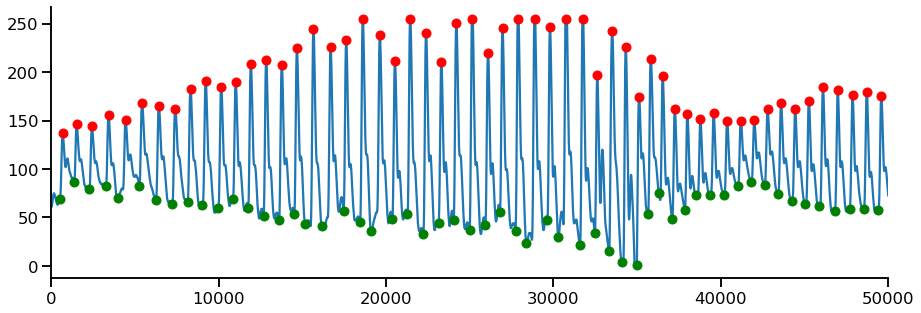

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(signal)
plt.plot(np.where(higher_peaks)[0], signal[np.where(higher_peaks)[0]], "ro")
plt.plot(np.where(lower_peaks)[0], signal[np.where(lower_peaks)[0]], "go")
plt.xlim(0, 50000)
sns.despine()

## Feature extraction

### 1 Higher peak 

In [8]:
x = np.where(higher_peaks)[0]
y = signal[higher_peaks]

xnew = np.arange(0, len(signal)/1000, 0.001)

# Interpolate
f = interp1d(
    x/1000, y, kind="linear", 
    fill_value="extrapolate"
)

higher_peaks_value = f(xnew)

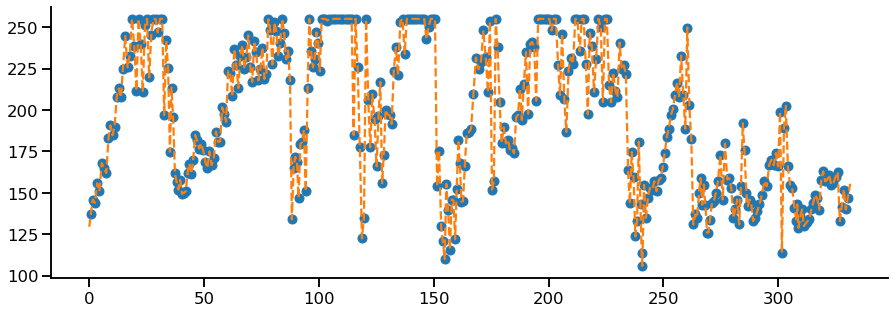

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(x/1000, y, "o")
plt.plot(xnew, higher_peaks_value, '--')
sns.despine()

### 2 Lower peak

In [10]:
# 2) value lower peaks (2 arrays)
x = np.where(lower_peaks)[0]
y = signal[lower_peaks]
xnew = np.arange(0, len(signal)/1000, 0.001)

# Interpolate
f = interp1d(
    x/1000, y, kind="linear", 
    fill_value="extrapolate"
)

lower_peaks_value = f(xnew)

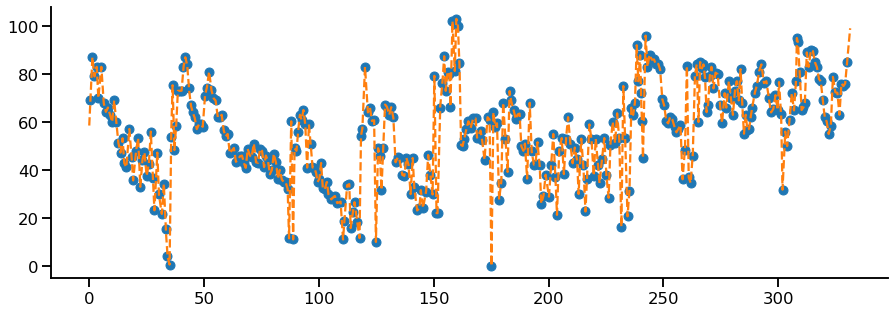

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(x/1000, y, "o")
plt.plot(xnew, lower_peaks_value, '--')
sns.despine()

### 3 Difference higher-lower

In [12]:
# Interpolate
x = np.where(lower_peaks)[0]
xnew = np.arange(0, len(signal)/1000, 0.001)
y = signal[higher_peaks] - signal[lower_peaks]

f = interp1d(
    x/1000,
    y,
    kind="linear", 
    fill_value="extrapolate",
)

# Use the peaks vector as time input
value_difference = f(xnew)

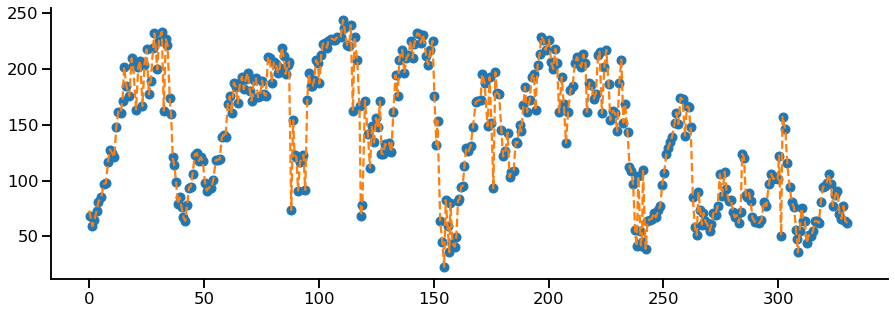

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(x/1000, y, "o")
plt.plot(xnew, value_difference, '--')
sns.despine()

### 4 Higher to higher interval

In [14]:
# Interpolate
x = np.where(lower_peaks)[0][1:]
xnew = np.arange(0, len(signal)/1000, 0.001)
y = np.diff(np.where(lower_peaks)[0])

f = interp1d(
    x/1000,
    y,
    kind="linear", 
    fill_value="extrapolate",
)

# Use the peaks vector as time input
higher_higher_interval = f(xnew)

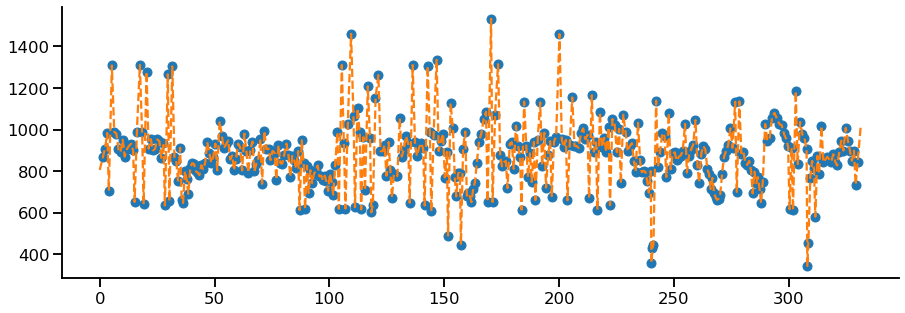

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(x/1000, y, "o")
plt.plot(xnew, higher_higher_interval, '--')
sns.despine()

### 5 Lower to lower interval

In [16]:
# Interpolate
x = np.where(higher_peaks)[0][1:]
xnew = np.arange(0, len(signal)/1000, 0.001)
y = np.diff(np.where(higher_peaks)[0])

f = interp1d(
    x/1000,
    y,
    kind="linear", 
    fill_value="extrapolate",
)

# Use the peaks vector as time input
lower_lower_interval = f(xnew)

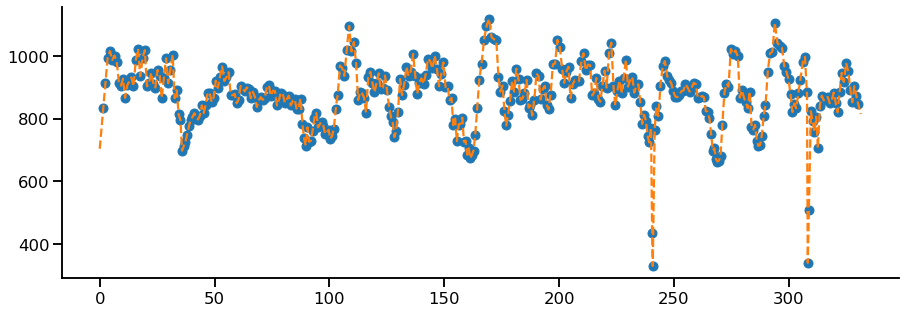

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(x/1000, y, "o")
plt.plot(xnew, lower_lower_interval, '--')
sns.despine()

In [18]:
len(lower_lower_interval), len(higher_higher_interval), len(value_difference), len(lower_peaks_value), len(higher_peaks_value)

(331294, 331294, 331294, 331294, 331294)

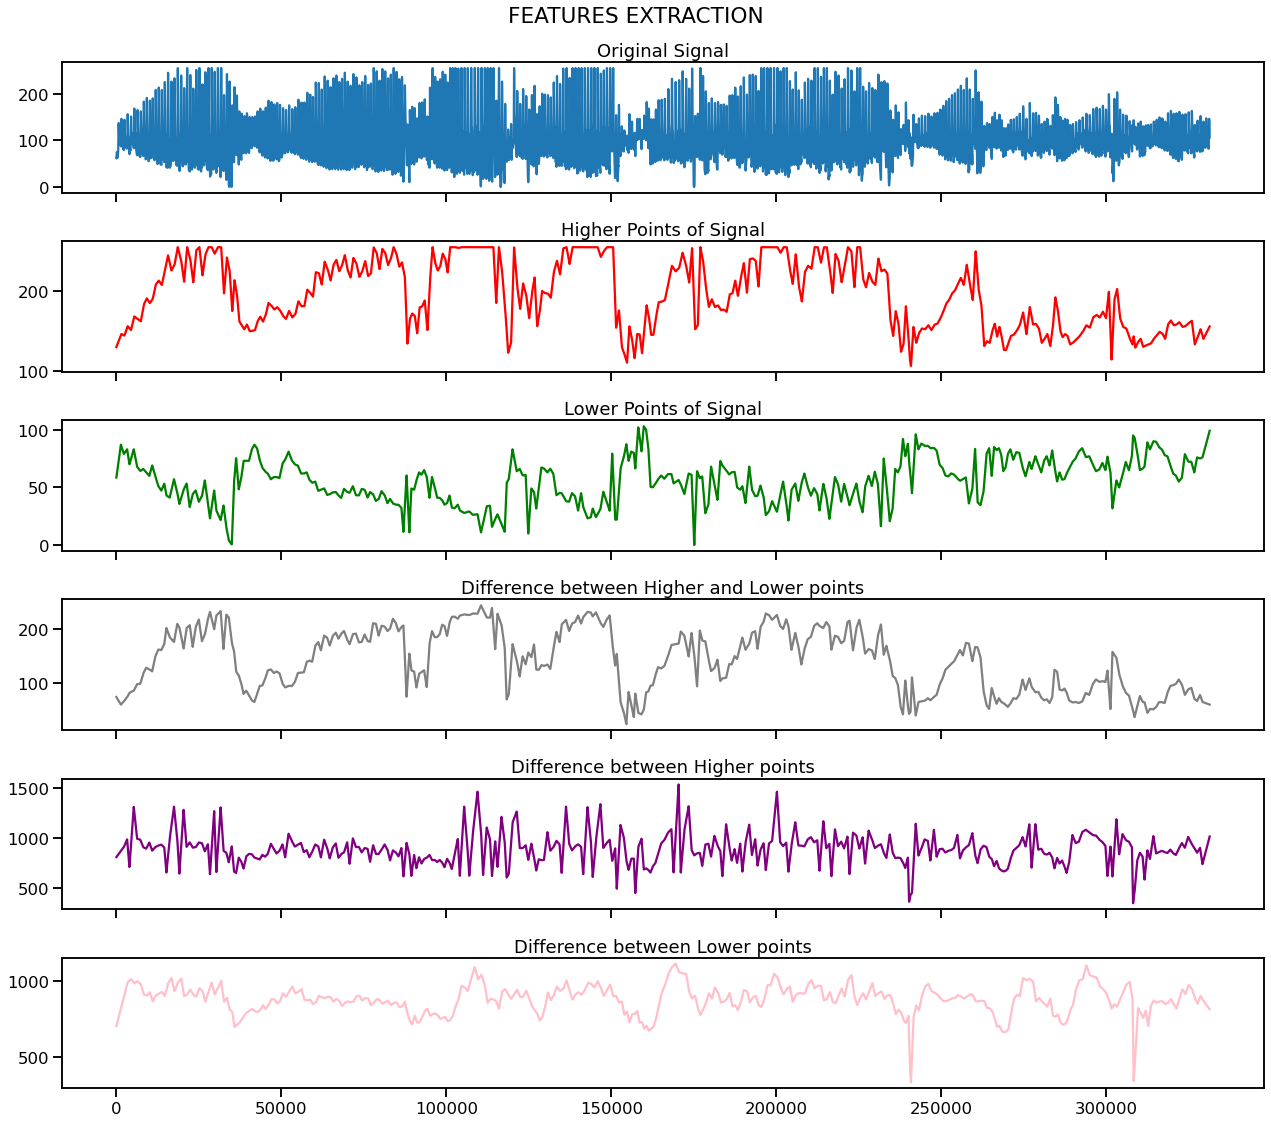

In [19]:
#five subplots
fig, axs = plt.subplots(6, sharex=True, figsize=(18,16))

fig.suptitle('FEATURES EXTRACTION')

axs[0].plot(signal)
axs[0].set_title('Original Signal')


axs[1].plot(higher_peaks_value, color='red')
axs[1].set_title('Higher Points of Signal')


axs[2].plot(lower_peaks_value, color='green')
axs[2].set_title('Lower Points of Signal')

axs[3].plot(value_difference, color='gray')
axs[3].set_title('Difference between Higher and Lower points')


axs[4].plot(higher_higher_interval, color='purple')
axs[4].set_title('Difference between Higher points')


axs[5].plot(lower_lower_interval, color='pink')
axs[5].set_title('Difference between Lower points')

plt.tight_layout()

## Extract frequency components

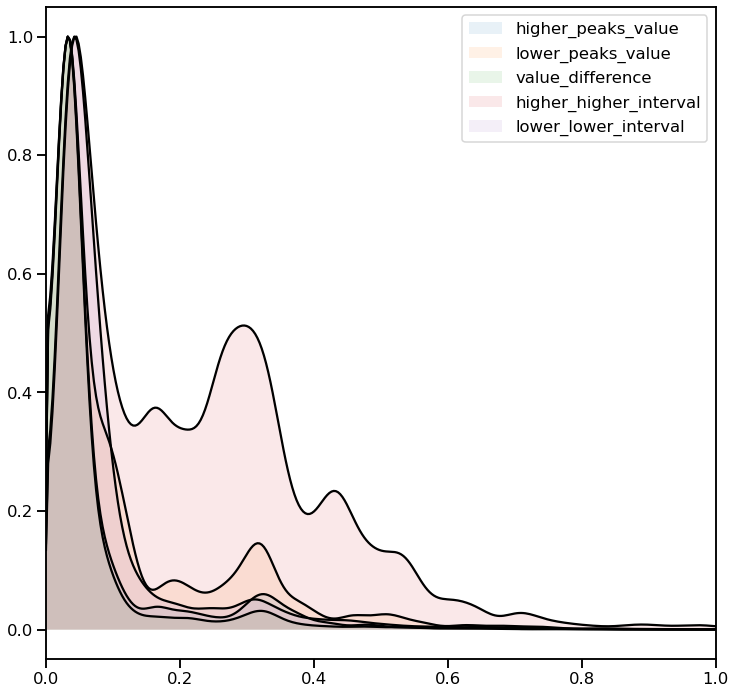

In [20]:
from scipy.signal import welch

_, ax = plt.subplots(1, 1, figsize=(12, 12))
for signal, label in zip([higher_peaks_value, lower_peaks_value, value_difference, higher_higher_interval, lower_lower_interval],
                        ["higher_peaks_value", "lower_peaks_value", "value_difference", "higher_higher_interval", "lower_lower_interval"]):
    # Define window length
    nperseg = 2048 * 15 #len(signal)

    # Compute Power Spectral Density
    freq, power = welch(x=signal, fs=1000, nperseg=nperseg, nfft=nperseg*10)

    power = power / 1000000
    power /= power.max()
    ax.plot(freq, power, color='k')
    ax.fill_between(freq, power, alpha=.1, label=label)
plt.xlim(0, 1)
plt.legend()